In [6]:
##########################################################################################################
#
#       APPLICATION  D'UNE METHODE D'ECHANTILLONNAGE D'IMPORTANCE (statique) POUR UNE SIMULATION BAYESIENNE A POSTERIORI
#
#
#
#
#                  Donnees X  ~ Loi NORMALE (THETA,1). La derniere donnee observee est
#                                                      censuree � droite.
#
#                  A priori sur THETA = Loi NORMALE (MU,1)
#                                             d'hyperparametre MU 
#
############################################################################################################


<img src="https://perso.lpsm.paris/~bousquet/yotta/tps/AR1a.png" alt="drawing" width="800"/>
<img src="https://perso.lpsm.paris/~bousquet/yotta/tps/IS1a.png" alt="drawing" width="800"/>


In [1]:
# %matplotlib notebook
import sys, os
sys.path.append('../')

# on introduit toujours les mêmes packages

import math as m
import statistics as s
import random as r
import numpy as np
import numpy.linalg as la
from numpy import random as rand

import scipy
# import scipy.ndimage as sn
# from scipy.ndimage.filters import gaussian_filter
from scipy.stats import norm
from scipy.stats import uniform
from statistics import mean

import pandas as pd
import seaborn as sns
#plt.rcParams['font.size'] = 20

import warnings
warnings.filterwarnings('ignore')

#sns.set()

log = np.vectorize(m.log)
exp = np.vectorize(m.exp)
sqrt = np.vectorize(m.sqrt)

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

In [18]:
#===============================================================================#
#
#      JEU DE DONNEES (15 DONNEES simulees selon la loi NORMALE (0,1) )
#         la derniere donneee est censuree � droite
#
#===============================================================================#

donnees = np.array(( 0.8114032, -0.4631576, -0.5984133,  1.5006175,  0.2123149, -1.0101033,1.0199253, -2.5994554, -0.3684774,  0.8263161,  0.4572680, -0.7240380,-0.3134977, -0.3772193, 6) )


In [25]:
#===============================================================================#
#
#              Algorithme d'Importance Sampling (echantillonnage d'importance, ou preferentiel, ou pondere....)
#
#         N         = nombre de tirages desires a posteriori
#         mu        = moyenne a priori pour X 
#         
#        option     =  1    : tirage instrumental (d'importance) dans la loi a posteriori en "oubliant" la donnee censuree 
#        option     =  2    : tirage instrumental (d'importance) dans la loi a priori
#                            
#
#
#
#===============================================================================#

def importance_sampling(option=2,N=5000,mu=0):

    # informations sur les donnees
    n = len(donnees)

    # log-densite de la loi a priori sur theta
    def log_prior(theta):
        return(- (1/2)*np.log(2*np.pi) - (1/2)*(theta-mu)**2)

    prior_dens = lambda x: np.exp(log_prior(x))

    # log-densite de la loi a posteriori sur theta definie � un facteur pres
    moy_post = (mu + np.sum(donnees[:-1]))/n 
    sigma_post = np.sqrt(1/n)
    def log_post(theta):
        ll1 = - (1/(2*sigma_post**2))*(theta-moy_post)**2              # terme gaussien regulier
        ll2 = np.log(1-norm.cdf((donnees[-1]-theta),0,1))                   # terme d� � la censure
        res = ll1 + ll2
        return res

    # log-densite de la loi de tirage de theta  
    if (option==1):                               # posterior sans tenir compte de la censure
        moy = moy_post
        sigma = sigma_post 
    else:                               # loi a priori
        moy = mu 
        sigma = 1
    log_instr = lambda theta: - (1/2)*np.log(2*np.pi) - np.log(sigma) - (1/(2*sigma**2))*(theta-moy)**2
    inst_dens = lambda x: np.exp(log_instr(x))



    #--------------- SIMULATION D'IMPORTANCE -----------------------------#
    NN = 20*N                # Heuristique de Rubin
    theta = norm.rvs(moy,sigma, size=NN)

    #--------------- CALCUL DES POIDS ------------------------------------#
    log_poids = log_post(theta) - log_instr(theta) 
    # gestion des pbs numeriques
    log_poids_pond = log_poids - np.median(log_poids) # rm.na=TRUE
    poids          = np.exp(log_poids_pond)
    # protection vis-�-vis des Not-A-Number (NAN) et des Inf
    poids[np.isnan(poids)]=0
    poids = poids/poids.sum()


    #-------------- ETAPE DE REECHANTILLONNAGE AVEC REMISE ---------------#
    # peut se faire sans normalisation des poids sous R
    theta_post = np.random.choice(theta,N,p=poids)


    #-------------- GRAPHIQUES -------------------------------------------#
    n_bins, _, _ = plt.hist(theta,40)
    idx_theta = np.argsort(theta)
    plt.plot(theta[idx_theta],poids[idx_theta]*max(n_bins)/max(poids), label='poids')
    plt.xlabel("theta (tirage instrumental)")
    plt.title("Hist. des tirages d'importance + distribution des poids")
    plt.legend()
    plt.show()

    # second graphique
    n_bins, _, _ = plt.hist(theta_post, min(40,int(sqrt(len(theta_post)))))
    x = np.linspace(min(donnees), max(donnees), 200)
    yo_max = max(n_bins)
    plt.title("Histogramme des simulations reechantillonnees")
    plt.xlabel("theta")
    plt.ylabel("densite")
    plt.plot(x,inst_dens(x)*yo_max, label='instrumntale')
    plt.plot(x,prior_dens(x)*yo_max, label="a priori")
    plt.scatter(donnees[:-1],np.zeros(n-1),label='donnees iid', c='B')
    plt.scatter(donnees[-1],0,label='censure', c='R')


    #--------------------------------------------------------------------------

    # estimation de la constante de normalisation � partir des poids non-normalises et validation graphique de la simulation obtenue
    constante_C = 1/np.mean(np.exp(log_poids)) #rm.na=TRUE 
    post_dens = lambda x: constante_C*np.exp(log_post(x))
    plt.plot(x,post_dens(x)*yo_max, label="a posteriori")
    plt.legend()
    plt.plot()


    #return(theta.post[1:N])


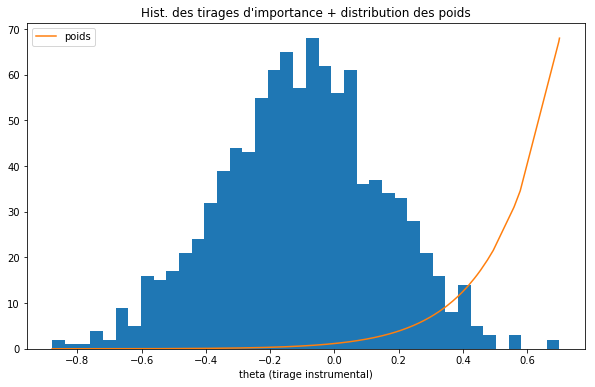

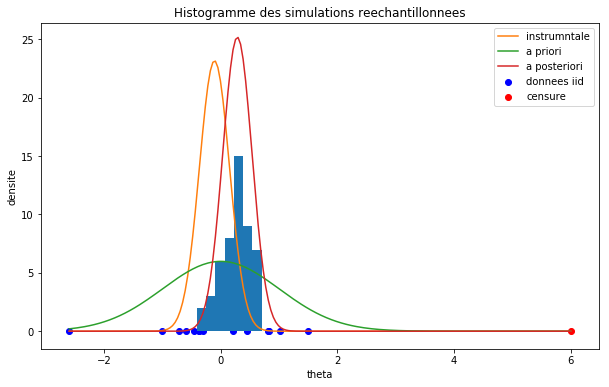

In [26]:
importance_sampling(option=1,N=50,mu=0)